In [3]:
# prompt: code for unzip

!unzip Dataset.zip


Archive:  Dataset.zip
  inflating: Dataset/data.yaml       
  inflating: Dataset/README.dataset.txt  
  inflating: Dataset/README.roboflow.txt  
   creating: Dataset/test/
   creating: Dataset/test/images/
  inflating: Dataset/test/images/bp_262118_4_174541_4_19_jpg.rf.83019ff6f2b13a182d37ac45375e012f.jpg  
  inflating: Dataset/test/images/bs_261926_4_174326_4_19_jpg.rf.7ef43d7affcd9fa599adedc52e911211.jpg  
  inflating: Dataset/test/images/cd_261945_4_174271_4_19_jpg.rf.75be230ab197842281564fb6447e7428.jpg  
  inflating: Dataset/test/images/cl_261910_4_174455_4_19_jpg.rf.bee3769739f7df98507f42e023b155e8.jpg  
  inflating: Dataset/test/images/cr_261969_4_174264_4_19_jpg.rf.de93c98ffc682d16dd91d862ff1d636c.jpg  
  inflating: Dataset/test/images/el_262187_4_174500_4_19_jpg.rf.001f03055ad8808501e9208e15f3764b.jpg  
  inflating: Dataset/test/images/vp_262092_4_174270_4_19_jpg.rf.b32574f90638f187c1a5812fa3bab06f.jpg  
  inflating: Dataset/test/images/vp_262096_4_174270_4_19_jpg.rf.334b9ef44

In [4]:
import numpy as np
import tensorflow as tf
from glob import glob

IMG_SIZE = (256,256)

def gen_example(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMG_SIZE)
    label_path = img_path.replace('/images/','/labels/').replace('.jpg','.txt')
    labels = np.loadtxt(label_path,delimiter=' ')
    label_wh = labels[:,[3,4]]
    label_xy = labels[:,[1,2]]
    boxes = np.hstack([label_xy-0.5*label_wh,label_xy+0.5*label_wh])
    boxes = boxes*(img.shape[:2]+img.shape[:2])
    K_loc = 0.5*(boxes[:,[2,3]]+boxes[:,[0,1]])
    K_bw = 0.5*(boxes[:,[2,3]]-boxes[:,[0,1]])
    ys, xs = np.ogrid[0:img.shape[0]:IMG_SIZE[0]*1j, 0:img.shape[1]:IMG_SIZE[1]*1j]
    dens = 0
    for (loc_x,loc_y),(bw_x,bw_y) in zip(K_loc,K_bw):
        bw_x, bw_y = 10,10 # use constant rather than actual size for simplicity
        dens_update = np.clip(1-np.abs(loc_x-xs)/bw_x,0,1)*np.clip(1-np.abs(loc_y-ys)/bw_y,0,1)
        # dens_update = dens_update * 1/dens_update.sum() # normalize
        dens = dens + dens_update
    return img,dens


def gen_data(subpath='train'):
    def gen():
        for img_path in glob(f'/content/Dataset/{subpath}/images/*.jpg'):
            img,dens = gen_example(img_path)
            yield img,dens
    return gen


train_ds = tf.data.Dataset.from_generator(
     gen_data('train'),
     output_signature=(
         tf.TensorSpec(shape=IMG_SIZE+(3,), dtype=tf.float32),
         tf.TensorSpec(shape=IMG_SIZE, dtype=tf.float32)
    )
)
train_ds = train_ds.shuffle(100).batch(32).prefetch(1).cache()

val_ds = tf.data.Dataset.from_generator(
     gen_data('valid'),
     output_signature=(
         tf.TensorSpec(shape=IMG_SIZE+(3,), dtype=tf.float32),
         tf.TensorSpec(shape=IMG_SIZE, dtype=tf.float32)
    )
)
val_ds = val_ds.shuffle(1000).batch(32).prefetch(1).cache()

test_ds = tf.data.Dataset.from_generator(
     gen_data('test'),
     output_signature=(
         tf.TensorSpec(shape=IMG_SIZE+(3,), dtype=tf.float32),
         tf.TensorSpec(shape=IMG_SIZE, dtype=tf.float32)
    )
)
test_ds = test_ds.batch(32).prefetch(1).cache()

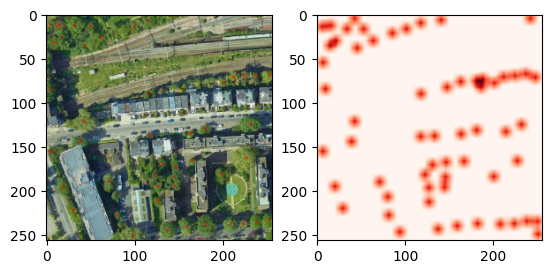

In [5]:
import matplotlib.pyplot as plt

img,dens = next(train_ds.unbatch().as_numpy_iterator())
fig,axs = plt.subplots(1,2)
axs[0].imshow(img)
axs[1].imshow(dens,cmap="Reds")
plt.show()

In [6]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models


def get_original_model():

    model = tf.keras.Sequential([

        layers.Conv2D(32,(5,5), input_shape=(256,256,3), padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2),strides=(2,2)),
        layers.Dropout(0.1),

        layers.Conv2D(64,(3,3), padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2), strides=(2,2)),
        layers.Dropout(0.1),

        layers.Conv2D(128,(3,3), padding='same'),
        layers.Activation('relu'),
        layers.Conv2D(256,(3,3), padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2),strides=(2,2)),
        layers.Dropout(0.1),

        layers.Conv2D(128,(1,1), padding='same'),
        layers.Activation('relu'),
        layers.Conv2D(1,(1,1), padding='same'),
        layers.Activation('relu'),

        layers.UpSampling2D(size=(8,8)),
        layers.Reshape((256,256)),
    ]
    )


    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),)

    return model

model = get_original_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 activation_1 (Activation)   (None, 128, 128, 64)      0         
                                                        

Epoch 1/500
2/2 [==============================] - 15s 2s/step - loss: 0.0601 - val_loss: 0.0530
Epoch 2/500
2/2 [==============================] - 0s 200ms/step - loss: 0.0546 - val_loss: 0.0518
Epoch 3/500
2/2 [==============================] - 0s 184ms/step - loss: 0.0555 - val_loss: 0.0520
Epoch 4/500
2/2 [==============================] - 0s 180ms/step - loss: 0.0537 - val_loss: 0.0534
Epoch 5/500
2/2 [==============================] - 0s 178ms/step - loss: 0.0532 - val_loss: 0.0541
Epoch 6/500
2/2 [==============================] - 0s 193ms/step - loss: 0.0530 - val_loss: 0.0530
Epoch 7/500
2/2 [==============================] - 0s 183ms/step - loss: 0.0520 - val_loss: 0.0511
Epoch 8/500
2/2 [==============================] - 0s 179ms/step - loss: 0.0513 - val_loss: 0.0497
Epoch 9/500
2/2 [==============================] - 0s 181ms/step - loss: 0.0511 - val_loss: 0.0492
Epoch 10/500
2/2 [==============================] - 0s 181ms/step - loss: 0.0504 - val_loss: 0.0495
Epoch 11/50

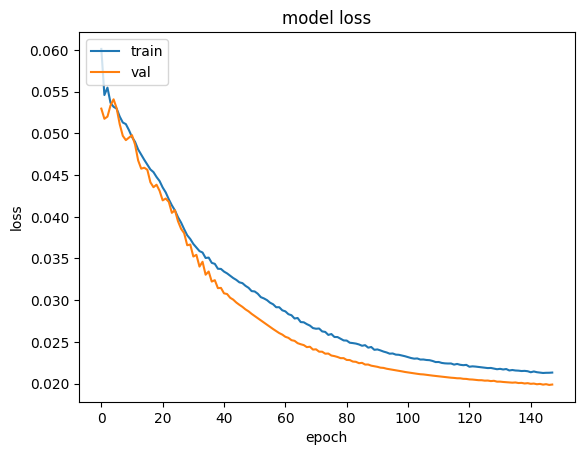

In [7]:
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(train_ds,validation_data=val_ds,epochs=500,callbacks=[early_stopper])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 [==============================] - 2s 2s/step


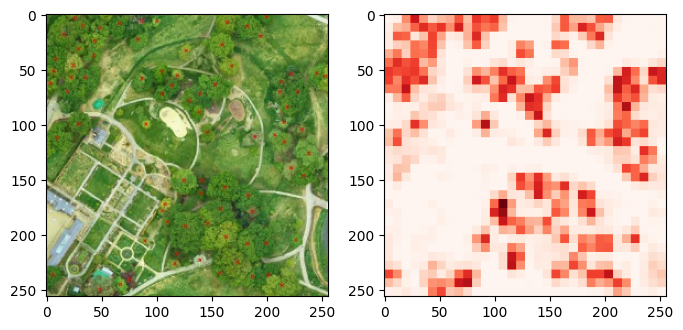

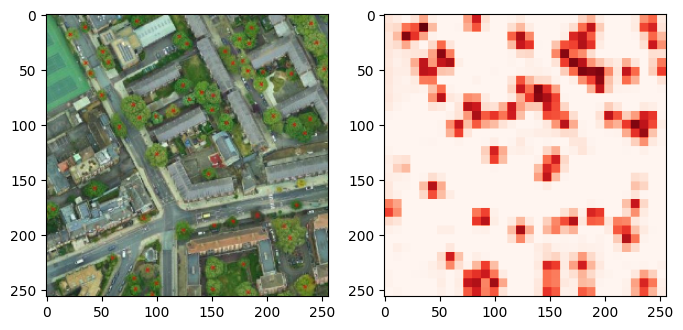

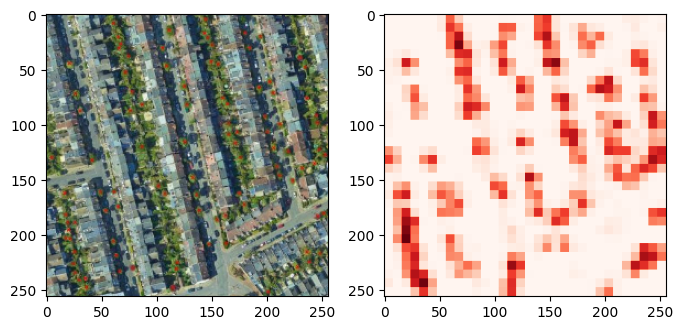

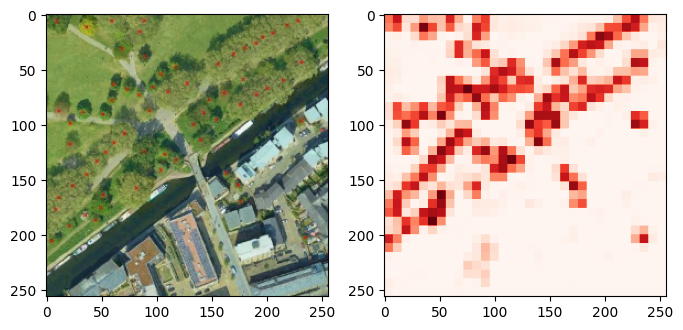

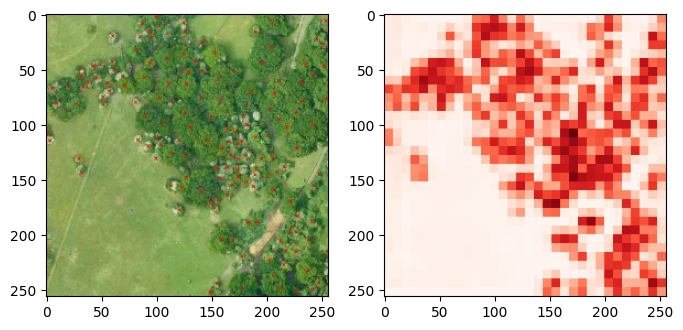

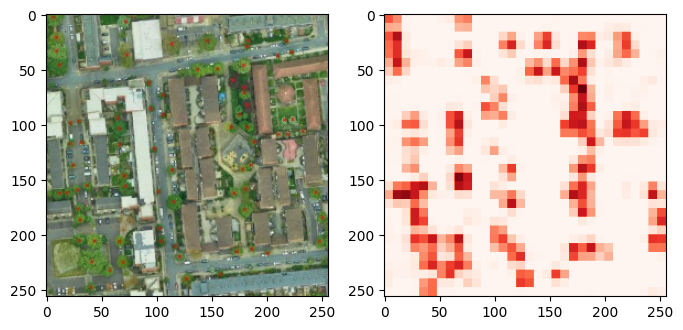

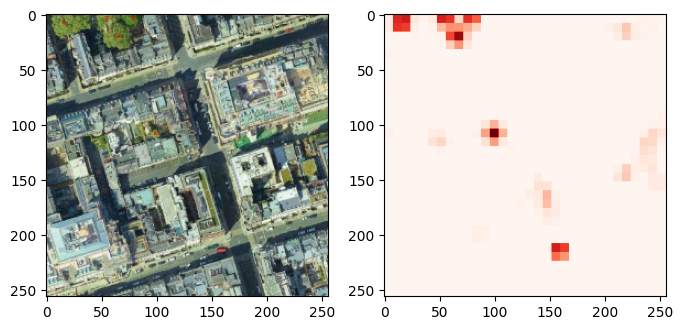

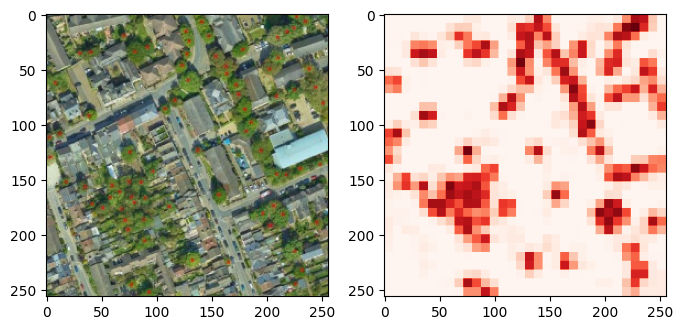

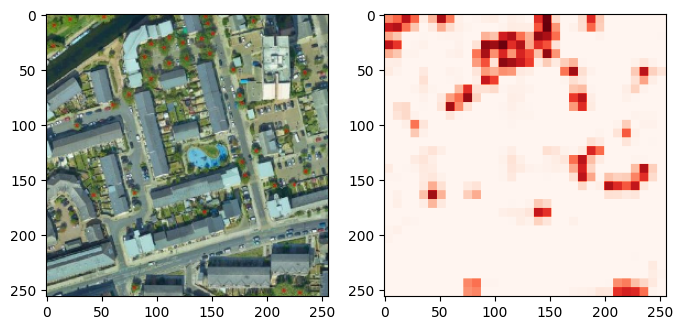

In [8]:
imgs_pred = model.predict(test_ds)
for img_pred,(img,_) in zip(imgs_pred,test_ds.unbatch().as_numpy_iterator()):
    fig,axs = plt.subplots(1,2,figsize=(8,4))
    axs[0].imshow(img)
    axs[1].imshow( img_pred, cmap="Reds" )
    plt.show()

In [9]:
from sklearn.metrics import r2_score

imgs_pred = model.predict(test_ds)
imgs_dens = np.stack( [dens for _,dens in test_ds.unbatch().as_numpy_iterator()] )
r2_score(imgs_pred.ravel(),imgs_dens.ravel())

1/1 [==============================] - 0s 37ms/step


0.21369115061202304

In [16]:
imgs_pred

array([[[0.00799005, 0.00799005, 0.00799005, ..., 0.        ,
         0.        , 0.        ],
        [0.00799005, 0.00799005, 0.00799005, ..., 0.        ,
         0.        , 0.        ],
        [0.00799005, 0.00799005, 0.00799005, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.01649429, 0.01649429, 0.01649429, ..., 0.        ,
         0.        , 0.        ],
        [0.01649429, 0.01649429, 0.01649429, ..., 0.        ,
         0.        , 0.        ],
        [0.01649429, 0.01649429, 0.01649429, ..., 0.        ,
         0.        , 0.        ]],

       [[0.06167206, 0.06167206, 0.06167206, ..., 0.04235844,
         0.04235844, 0.04235844],
        [0.06167206, 0.06167206, 0.06167206, ..., 0.04235844,
         0.04235844, 0.04235844],
        [0.06167206, 0.06167206, 0.06167206, ..., 0.04235844,
         0.04235844, 0.04235844],
        ...,
        [0.00167745, 0.00167745, 0.00167745, ..., 0.02834737,
         0.02834737, 0.02834737],
        [0.0

In [19]:
total_dens_pred = tf.reduce_sum(imgs_pred, axis=[1,2]).numpy()
total_dens_pred

array([ 8145.872 ,  6410.2705,  7944.7104,  6315.496 , 13520.1455,
        6189.8516,   761.4743,  7976.666 ,  3294.046 ], dtype=float32)

array([[ 8145.872 ],
       [ 6410.2705],
       [ 7944.7104],
       [ 6315.496 ],
       [13520.1455],
       [ 6189.8516],
       [  761.4743],
       [ 7976.666 ],
       [ 3294.046 ]], dtype=float32)

In [12]:
# prompt: export the model in onmx format

!pip install tf2onnx
import tf2onnx

# Save the model as an ONNX file
spec = (tf.TensorSpec((None, 256, 256, 3), tf.float32, name="input"),)
output_path = "model.onnx"
model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13, output_path=output_path)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 49.7 MB/s eta 0:00:00


In [27]:
# prompt: write a code to predict the count of tree using the model

import numpy as np
def predict_count(image_path, model):
  """Predicts the count of trees in an image using the provided model.

  Args:
    image_path: Path to the image file.
    model: The trained Keras model.

  Returns:
    The predicted count of trees.
  """

  img = tf.io.read_file(image_path)
  img = tf.io.decode_jpeg(img)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, IMG_SIZE)
  img = tf.expand_dims(img, axis=0)  # Add batch dimension

  prediction = model.predict(img)
  print(prediction.data)
  count = np.sum(prediction)  # Sum the predicted density map

  return count

# Example usage:
image_path = '/content/Dataset/test/images/vp_262096_4_174270_4_19_jpg.rf.334b9ef442e980c50d5d79f4a9128a7c.jpg'  # Replace with the actual image path
predicted_count = predict_count(image_path, model)
print("Predicted count:", predicted_count*0.012366085)


1/1 [==============================] - 0s 29ms/step
[[[0.25452787 0.25452787 0.25452787 ... 0.0012918  0.0012918  0.0012918 ]
  [0.25452787 0.25452787 0.25452787 ... 0.0012918  0.0012918  0.0012918 ]
  [0.25452787 0.25452787 0.25452787 ... 0.0012918  0.0012918  0.0012918 ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]]
Predicted count: 40.73445761210694


NameError: name 'prediction' is not defined

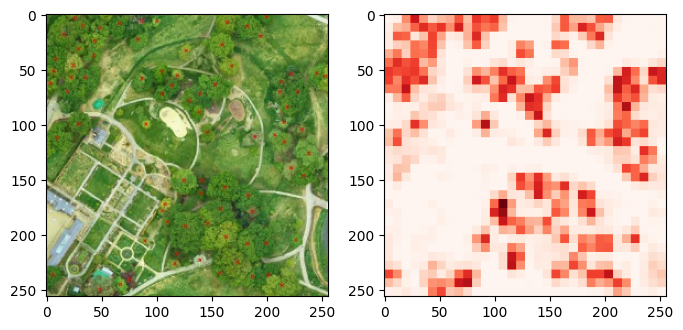

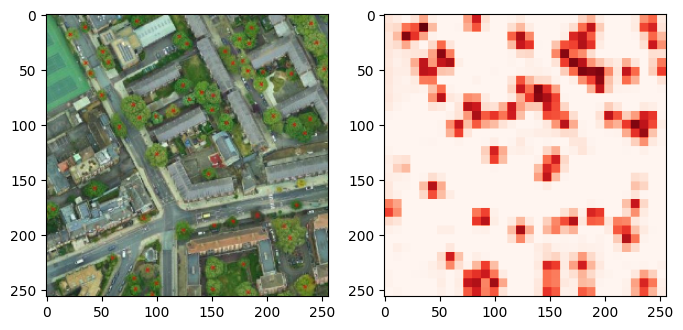

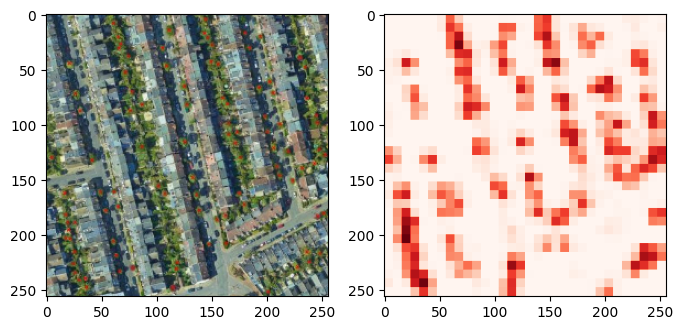

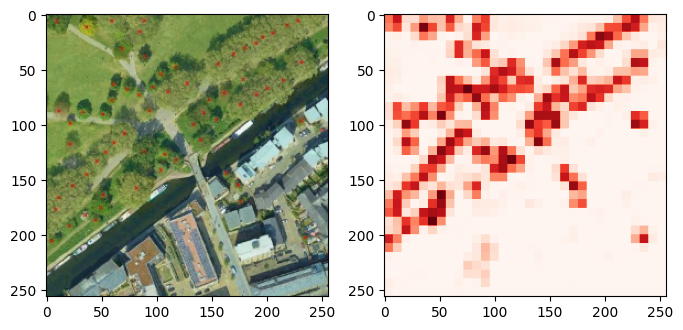

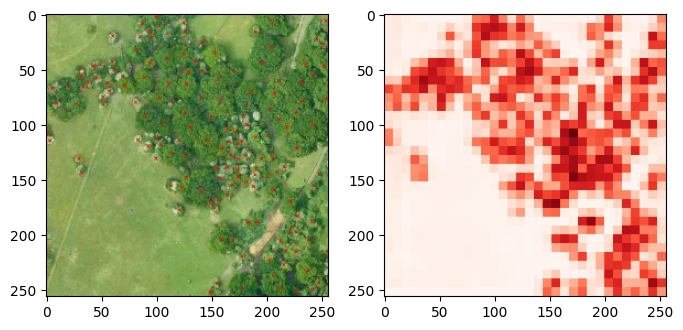

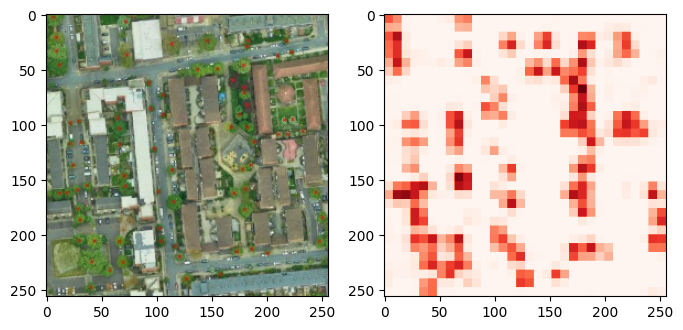

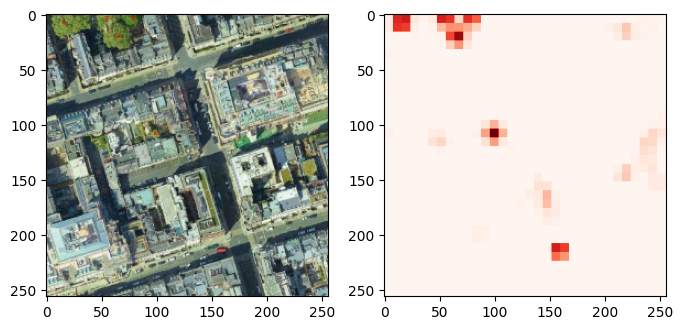

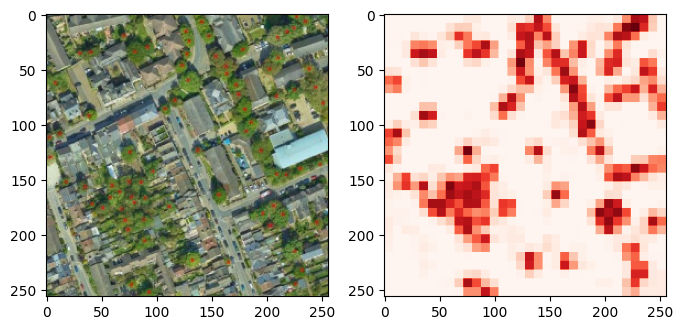

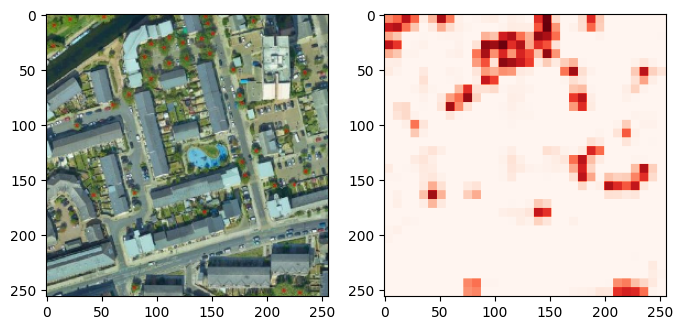

In [24]:
# prompt: write a code to show the output, plot

import matplotlib.pyplot as plt
# Assuming 'imgs_pred' contains the model predictions and 'test_ds' is the test dataset
for img_pred, (img, _) in zip(imgs_pred, test_ds.unbatch().as_numpy_iterator()):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(img)
    axs[1].imshow(img_pred, cmap="Reds")
    plt.show()


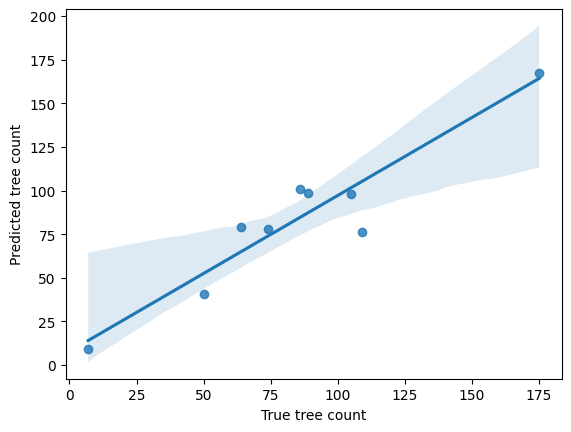

In [11]:
from sklearn.linear_model import LinearRegression
import seaborn as sns

tree_cnt = []
subpath = 'test'
for img_path in glob(f'/content/Dataset/{subpath}/images/*.jpg'):
    label_path = img_path.replace('/images/','/labels/').replace('.jpg','.txt')
    labels = np.loadtxt(label_path,delimiter=' ')
    tree_cnt.append(len(labels))
tree_cnt = np.array(tree_cnt)

# Sum along axis 1 and 2 (height and width) to get total density per image
total_dens_pred = tf.reduce_sum(imgs_pred, axis=[1,2]).numpy()
density_constant = LinearRegression().fit(total_dens_pred.reshape(-1,1),tree_cnt).coef_[0]

# Recalculate total_dens_pred after fitting the linear regression
total_dens_pred = tf.reduce_sum(imgs_pred, axis=[1,2]).numpy()

fig,ax = plt.subplots()
sns.regplot(x=tree_cnt,y=total_dens_pred*density_constant,ax=ax)
ax.set_xlabel('True tree count')
ax.set_ylabel('Predicted tree count')
plt.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.2 MB/s eta 0:00:00


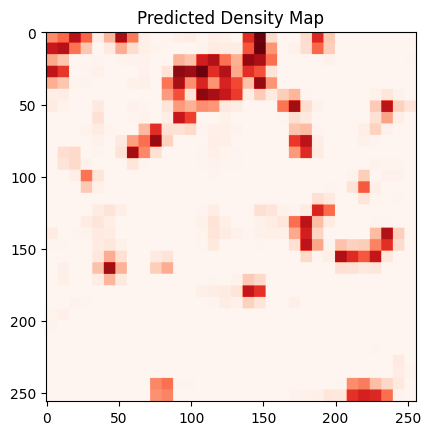

In [28]:


import matplotlib.pyplot as plt
!pip install onnxruntime

import onnxruntime as ort

# Load the ONNX model
ort_session = ort.InferenceSession('model.onnx')

# Preprocess the input image
image_path = '/content/Dataset/test/images/vp_262096_4_174270_4_19_jpg.rf.334b9ef442e980c50d5d79f4a9128a7c.jpg'  # Replace with the actual image path
img = tf.io.read_file(image_path)
img = tf.io.decode_jpeg(img)
img = tf.image.convert_image_dtype(img, tf.float32)
img = tf.image.resize(img, IMG_SIZE)
img_array = tf.expand_dims(img, axis=0).numpy()  # Add batch dimension and convert to NumPy array

# Run inference on the ONNX model
ort_inputs = {ort_session.get_inputs()[0].name: img_array}
ort_outs = ort_session.run(None, ort_inputs)

# Extract the predicted density map
predicted_density = ort_outs[0][0]

# Plot the predicted density map
plt.imshow(predicted_density, cmap="Reds")
plt.title('Predicted Density Map')
plt.show()


In [30]:
predicted_density

array([[0.25452787, 0.25452787, 0.25452787, ..., 0.00129181, 0.00129181,
        0.00129181],
       [0.25452787, 0.25452787, 0.25452787, ..., 0.00129181, 0.00129181,
        0.00129181],
       [0.25452787, 0.25452787, 0.25452787, ..., 0.00129181, 0.00129181,
        0.00129181],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [31]:
ort_outs

[array([[[0.25452787, 0.25452787, 0.25452787, ..., 0.00129181,
          0.00129181, 0.00129181],
         [0.25452787, 0.25452787, 0.25452787, ..., 0.00129181,
          0.00129181, 0.00129181],
         [0.25452787, 0.25452787, 0.25452787, ..., 0.00129181,
          0.00129181, 0.00129181],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]]], dtype=float32)]

In [ ]:


async function runInference() {
  // Load the ONNX model
  const session = await ort.InferenceSession.create('model.onnx');

  // Preprocess the input image (replace with your image loading logic)
  const imageData = await loadImage('path/to/image.jpg');
  const preprocessedData = preprocessImage(imageData); // Implement your preprocessing function

  // Create an ONNX Runtime tensor from the preprocessed image data
  const inputTensor = new ort.Tensor('float32', preprocessedData, [1, 256, 256, 3]); // Adjust shape as needed

  // Run inference on the ONNX model
  const feeds = { [session.inputNames[0]]: inputTensor };
  const results = await session.run(feeds);

  // Extract the predicted density map
  const predictedDensity = results[session.outputNames[0]].data;

  // Postprocess and visualize the results (implement your visualization logic)
  displayResults(predictedDensity);
}

// Helper functions (implement these according to your needs)
async function loadImage(imagePath) {
  // Load image data from the given path
}

function preprocessImage(imageData) {
  // Preprocess the image data (resize, normalize, etc.)
}

function displayResults(predictedDensity) {
  // Display the predicted density map (e.g., using a canvas)
}

// Run the inference
runInference();
